In [1]:
import numpy as np
# import pandas as pd
import volpriceinference as vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = False

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.01,
               'log_scale': np.log(252 * 1.564e-5),
               'log_delta': np.log(0.6475),
               'rho': .5,
              }
else:
     true_params ={'log_delta': -1.42,
                   'rho':0.69,
                   'log_scale': 1.85,
                   'phi': -.3,
                   'pi': -.07,
                   'theta': .42}
    
time_dim = 37000
sim_dim = 500
innov_dim = 250

In [6]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], log_scale=true_params['log_scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [7]:
def compute_moments(log_delta, rho, log_scale, phi, pi, theta):
    
    vol_mean = np.exp(log_scale +  log_delta) / (1 - rho)
    vol_var = (2 * np.exp(log_scale) * rho * vol_mean + np.exp(log_scale)**2 * np.exp(log_delta)) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, log_scale=log_scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(log_delta=log_delta, rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [8]:
compute_moments(**true_params)

{'return_mean': 0.08493110150315508,
 'return_var': 8.396600146536628,
 'vol_mean': 4.958895237252521,
 'vol_var': 101.73444754972846}

In [9]:
vl.compute_gamma(**true_params)

0.285723601298459

In [10]:
total_true_params

{'log_delta': -1.42,
 'rho': 0.69,
 'log_scale': 1.85,
 'phi': -0.3,
 'pi': -0.07,
 'theta': 0.42,
 'gamma': 0.285723601298459,
 'beta': 0.1164256389610225,
 'psi': -0.1569170166144357,
 'zeta': 0.91}

In [11]:
true_params

{'log_delta': -1.42,
 'rho': 0.69,
 'log_scale': 1.85,
 'phi': -0.3,
 'pi': -0.07,
 'theta': 0.42}

In [12]:
total_true_params

{'log_delta': -1.42,
 'rho': 0.69,
 'log_scale': 1.85,
 'phi': -0.3,
 'pi': -0.07,
 'theta': 0.42,
 'gamma': 0.285723601298459,
 'beta': 0.1164256389610225,
 'psi': -0.1569170166144357,
 'zeta': 0.91}

## We start by examining the distributions of simulated data

In [13]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [14]:
data.corr()

,vol,rtn
vol,1.000000,-0.310475
rtn,-0.310475,1.000000


In [15]:
data.vol.var()

103.10190114204286

In [16]:
init_constants = vl.compute_init_constants(data.vol)

In [17]:
init_constants

{'rho': 0.6861141035370063,
 'log_scale': 1.8703867101242158,
 'log_delta': -1.422513610591216}

In [18]:
vl.compute_vol_gmm(data.vol, init_constants)

({'log_delta': -1.422428934204877,
  'log_scale': 1.8705973904199467,
  'rho': 0.6860761247749759},
            log_delta  log_scale       rho
 log_delta   0.000341  -0.000138 -0.000063
 log_scale  -0.000138   0.000283 -0.000011
 rho        -0.000063  -0.000011  0.000072)

In [19]:
omega, omega_cov = vl.estimate_params(data)

In [20]:
omega

{'gamma': 0.28566642955865545,
 'beta': 0.11644484004403795,
 'psi': -0.1530744780850135,
 'zeta': 0.9203444674920515,
 'log_delta': -1.422428934204877,
 'log_scale': 1.8705973904199467,
 'rho': 0.6860761247749759}

In [21]:
omega_cov

,beta,gamma,log_delta,log_scale,psi,rho,zeta
beta,5.511168e-10,-8.872690e-10,0.000000,0.000000,-3.731540e-10,0.000000,0.000000
gamma,-8.872690e-10,7.166481e-09,0.000000,0.000000,-5.501217e-10,0.000000,0.000000
log_delta,0.000000e+00,0.000000e+00,0.000341,-0.000138,0.000000e+00,-0.000063,0.000000
log_scale,0.000000e+00,0.000000e+00,-0.000138,0.000283,0.000000e+00,-0.000011,0.000000
psi,-3.731540e-10,-5.501217e-10,0.000000,0.000000,4.990055e-06,0.000000,0.000000
rho,0.000000e+00,0.000000e+00,-0.000063,-0.000011,0.000000e+00,0.000072,0.000000
zeta,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000045


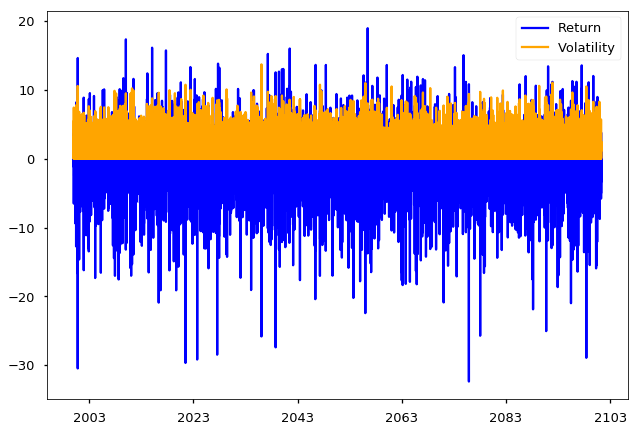

In [22]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [23]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,2.747573,-1.139080
rtn,-1.139080,5.924157


In [24]:
total_true_params

{'log_delta': -1.42,
 'rho': 0.69,
 'log_scale': 1.85,
 'phi': -0.3,
 'pi': -0.07,
 'theta': 0.42,
 'gamma': 0.285723601298459,
 'beta': 0.1164256389610225,
 'psi': -0.1569170166144357,
 'zeta': 0.91}

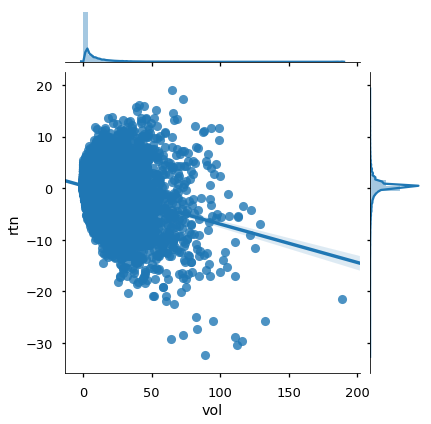

In [25]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [26]:
data.describe()

,vol,rtn
count,37000.000000,37000.000000
mean,4.985655,0.103048
std,10.153911,2.433959
min,0.000010,-32.376818
25%,0.046310,-0.255552
50%,0.808591,0.321115
75%,5.104318,0.863241
max,188.787623,18.998849


## I now estimate all of the parameters

In [27]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [28]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [29]:
estimator(data_arr[2])

({'gamma': 0.28577136858104696,
  'beta': 0.1163936852925643,
  'psi': -0.15979637719508902,
  'zeta': 0.9054053227590904,
  'log_delta': -1.4674241216071642,
  'log_scale': 1.8661161888842324,
  'rho': 0.6953816045173115,
  'phi': -0.3047425309981416,
  'pi': -0.06664354064240399,
  'theta': 0.4160035244690167},
                    beta         gamma  log_delta  log_scale       phi  \
 beta       5.870907e-10 -9.220703e-10   0.000000   0.000000       NaN   
 gamma     -9.220703e-10  6.966339e-09   0.000000   0.000000       NaN   
 log_delta  0.000000e+00  0.000000e+00   0.000369  -0.000136       NaN   
 log_scale  0.000000e+00  0.000000e+00  -0.000136   0.000303       NaN   
 phi                 NaN           NaN        NaN        NaN  0.000118   
 pi                  NaN           NaN        NaN        NaN  0.000002   
 psi       -3.988251e-10 -5.002969e-10   0.000000   0.000000       NaN   
 rho        0.000000e+00  0.000000e+00  -0.000075  -0.000015       NaN   
 theta             

In [30]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr[:200]),
                                      total=len(data_arr[:200])))

In [31]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [32]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_delta=true_params['log_delta'],
                                                   rho=true_params['rho'], log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

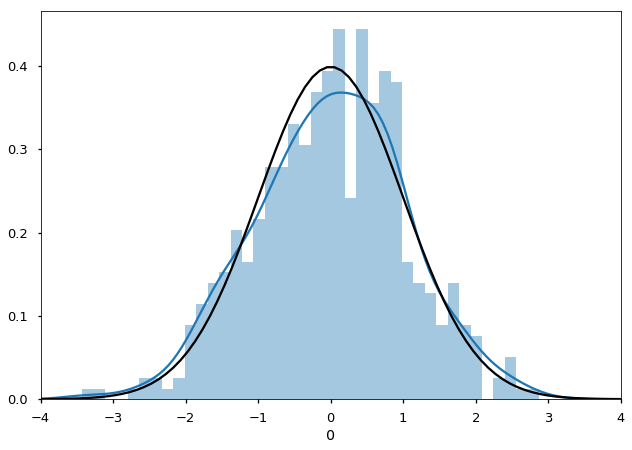

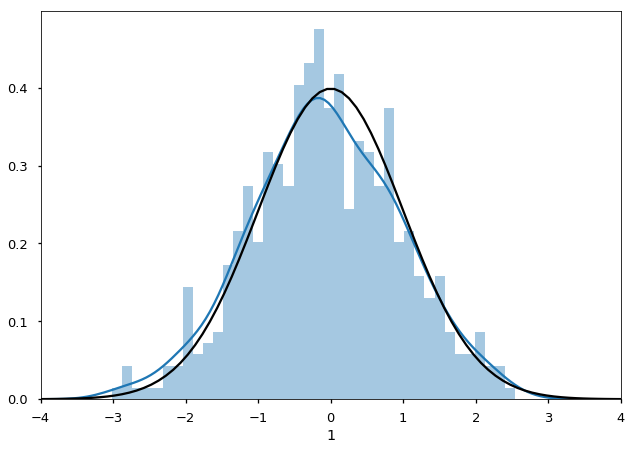

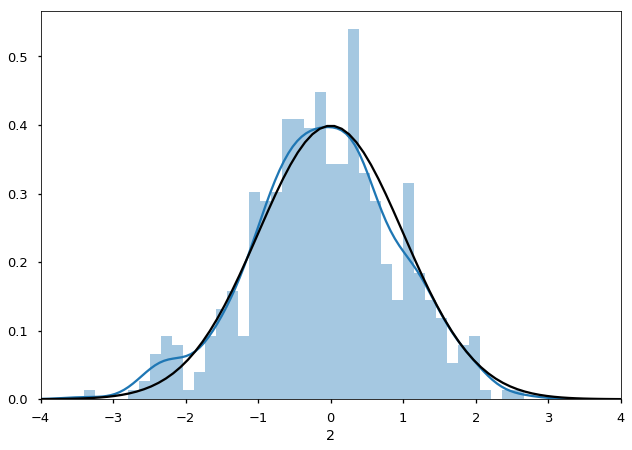

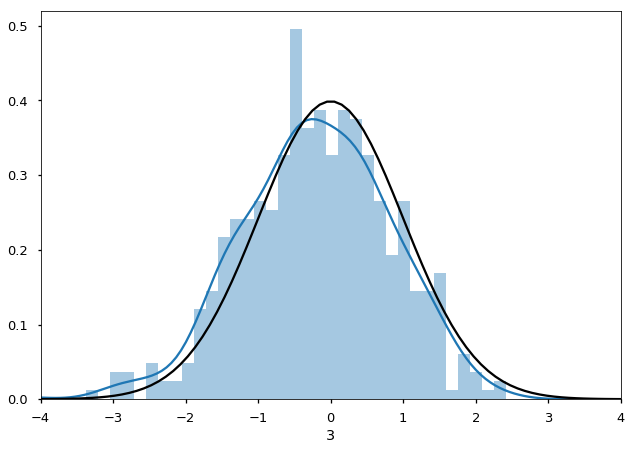

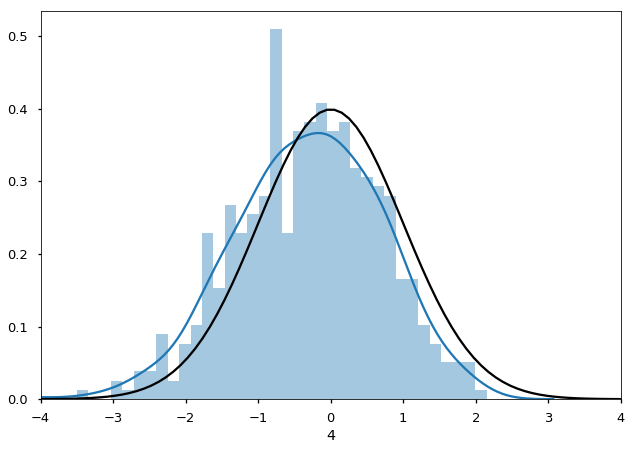

In [33]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

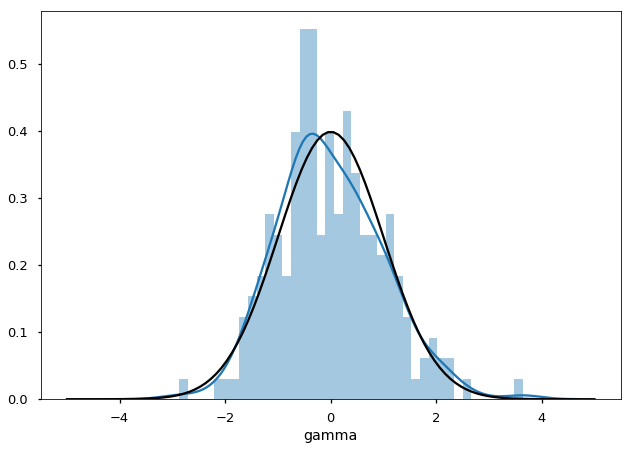

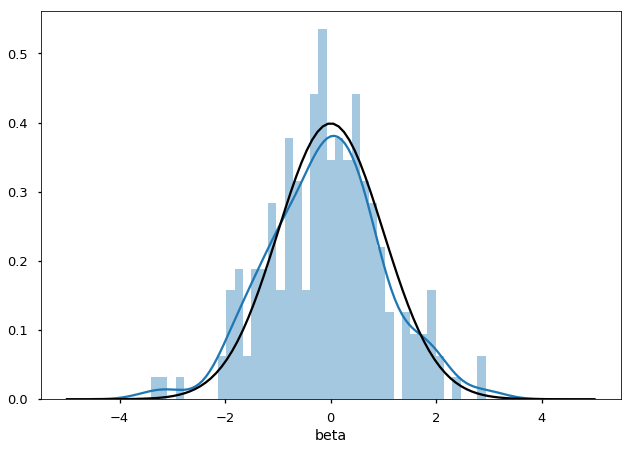

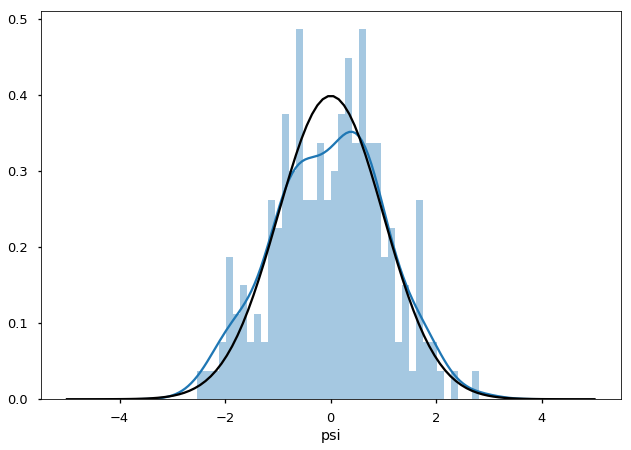

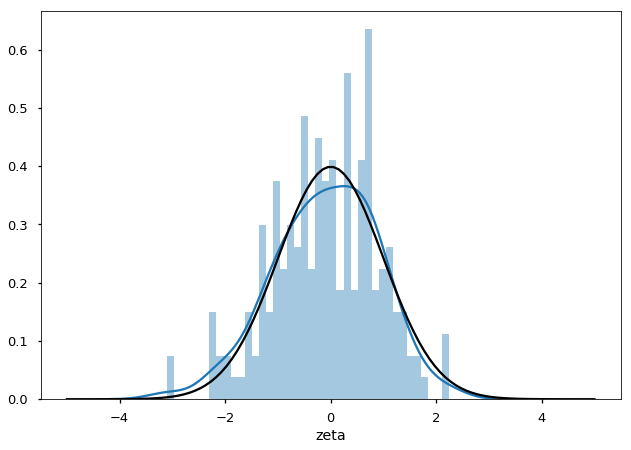

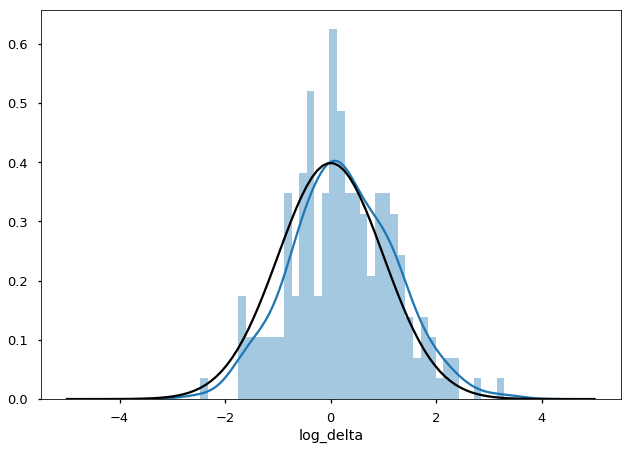

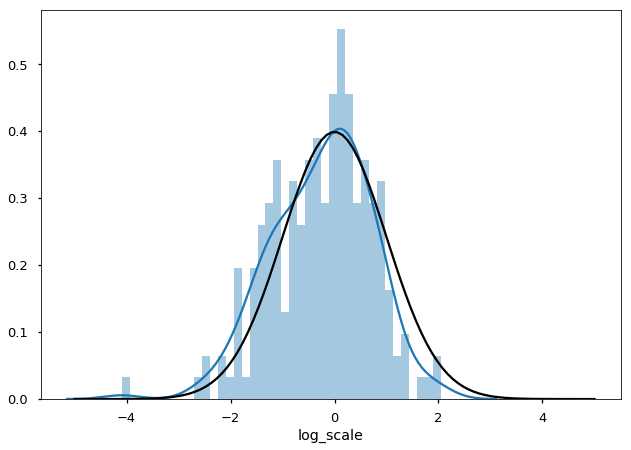

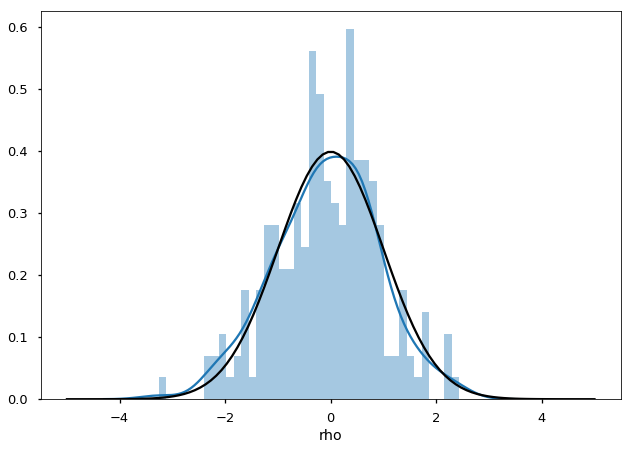

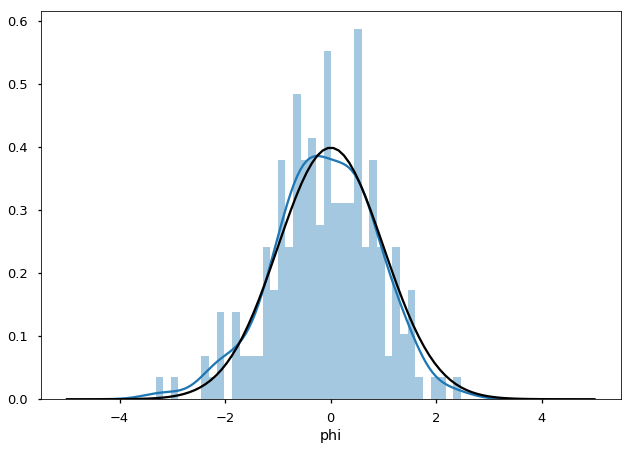

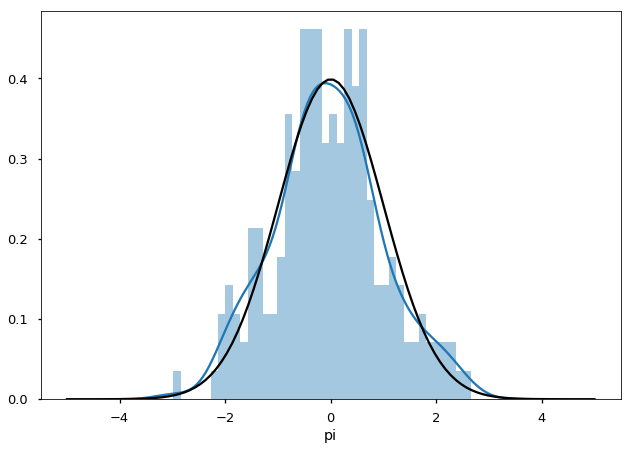

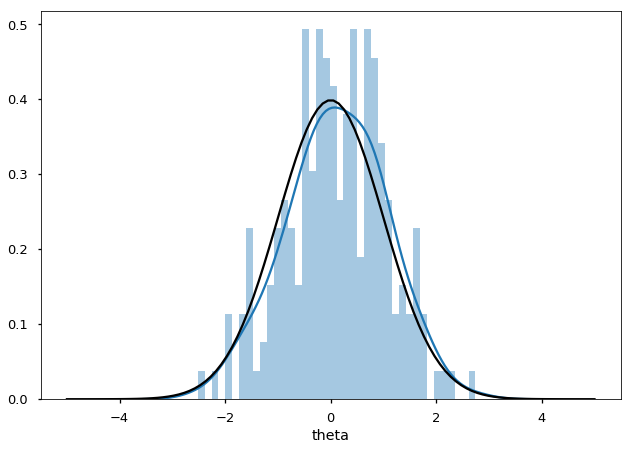

In [34]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
#         if max(ax.get_xlim()) > 20:
#             ax.set_xlim(-20, 20)

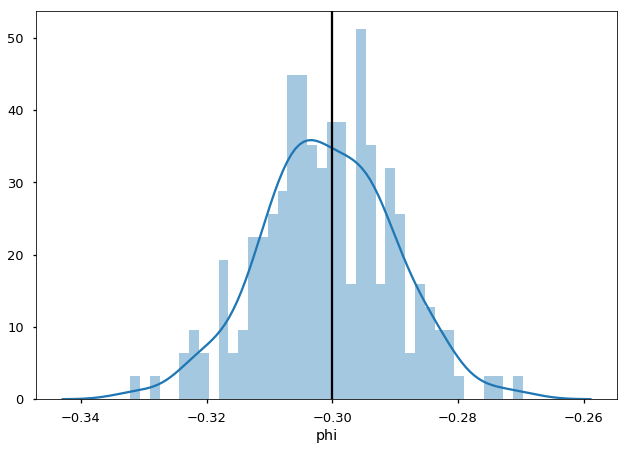

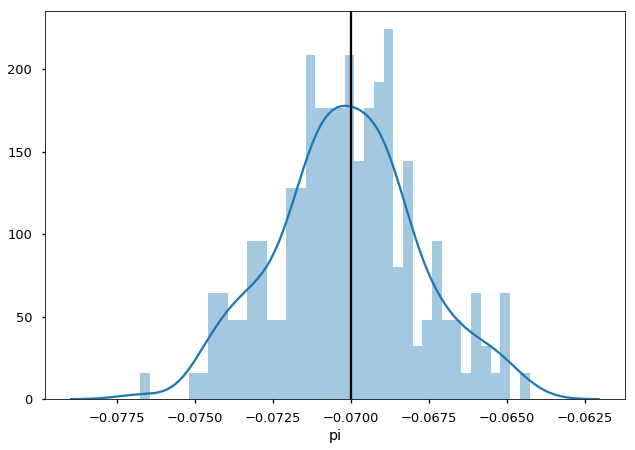

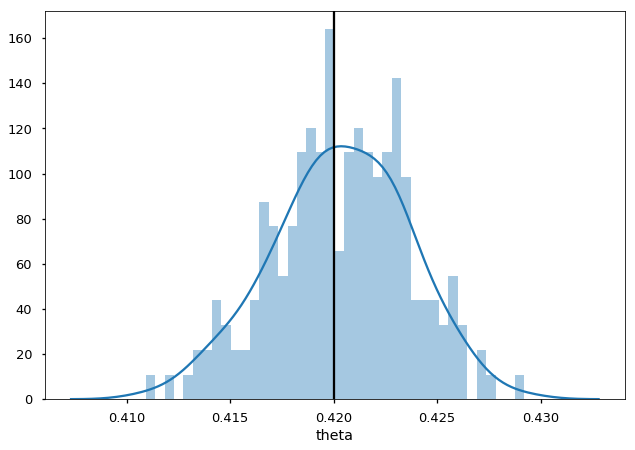

In [35]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        ax.axvline(total_true_params[name], color='black')
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

# I now compute the robust conditional QLR statistic 

In [36]:
omega


{'gamma': 0.28566642955865545,
 'beta': 0.11644484004403795,
 'psi': -0.1530744780850135,
 'zeta': 0.9203444674920515,
 'log_delta': -1.422428934204877,
 'log_scale': 1.8705973904199467,
 'rho': 0.6860761247749759}

In [37]:
true_params

{'log_delta': -1.42,
 'rho': 0.69,
 'log_scale': 1.85,
 'phi': -0.3,
 'pi': -0.07,
 'theta': 0.42}

In [38]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [39]:
def compute_ar(params, case=1):
    param_est, param_cov = params
    names = vl.compute_names(case)
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov, case=case)

In [59]:
param_est, param_cov = est_arr[0]
names = vl.compute_names(1)
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
# data.shape[0] * vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
vl.compute_link(prices=true_prices, omega=omega, case=1)

array([3.302e-05, 1.882e-03, 4.527e-05, 4.758e-03])

In [61]:
vl._link_grad_in1(*true_prices, **omega)

array([[ 1.   ,  0.   ,  0.   ,  0.03 ,  0.   , -0.168,  0.   ],
       [ 0.   ,  1.   , -0.284, -0.198,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.042,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -1.   ]])

In [40]:
compute_ar(est_arr[0])

0.7124500140914869

In [41]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

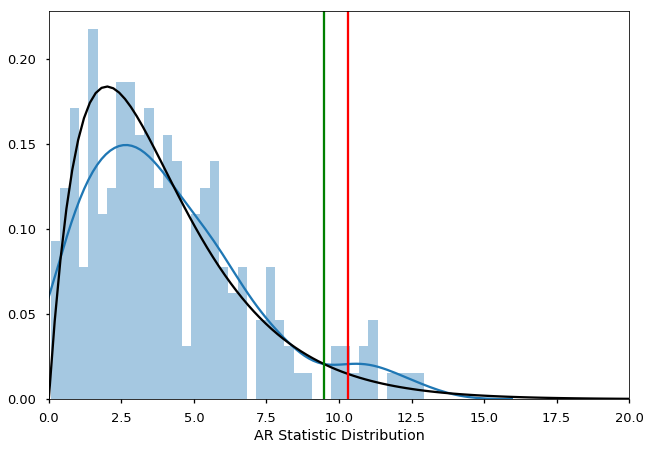

In [42]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [43]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [44]:
 stats.chi2.ppf(df=4, q=.95)

9.487729036781154

In [45]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

0    7.0
dtype: float64

In [46]:
# results[results <=0] = 0 

In [47]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [48]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [49]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [50]:
# returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
#                                         robust_quantile=True)

In [51]:
returnval.head()

NameError: name 'returnval' is not defined

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)